In [ ]:
from medaidml import DATA_DIR, DATA_TRAIN_JSON, DATA_TEST_JSON, ROOT_DIR
from medaidml.utils import split_val_test, json_to_dataframe

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk

from scipy.signal import welch

import json
import os

nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords_german")
nltk.download("stopwords_spanish")
nltk.download("stopwords_french")

all_df = json_to_dataframe(DATA_TRAIN_JSON)
no_dataleak_df = json_to_dataframe(DATA_TEST_JSON)

train_df, val_df, test_df = split_val_test(all_df, seed=1)

labels = {
    0: "Human",
    1: "AI"
}

len(all_df), len(no_dataleak_df)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


(10792, 2500)

In [9]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english") + stopwords.words("french") + stopwords.words("german") + stopwords.words("spanish"))  # O(1) look-ups

def stem_tokenise(text: str) -> list[str]:
    """Lower-case, tokenise, remove punctuation & stop-words, then stem."""
    tokens = [t for t in word_tokenize(text.lower())
              if t.isalpha()]  # and t not in stop_words]
    return [stemmer.stem(t) for t in tokens]

def calculate_correlations(df):
    # ------------------------------------------------------------------
    # 2. Load data
    # ------------------------------------------------------------------
    texts = df["text"].to_list()
    labels = df["target"].to_numpy()
    n_docs = labels.size
    print(f"Loaded {n_docs} documents")

    # ------------------------------------------------------------------
    # 3. Document-term matrix (binary of shape: n_docs × n_words)
    # ------------------------------------------------------------------
    print("Vectorising...")
    vectoriser = CountVectorizer(
        tokenizer=stem_tokenise,   # our custom pipeline
        binary=True,            # presence/absence, not counts
        lowercase=False            # already lower-cased in tokenizer
    )
    X = vectoriser.fit_transform(texts)         # shape = (n_docs, n_words)
    print(f"Vectorised to {X.shape[0]} documents and {X.shape[1]} words")

    # ------------------------------------------------------------------
    # 4. Vectorised Pearson correlation for every word
    # ------------------------------------------------------------------
    print("Calculating correlations...")
    # Means
    p = X.mean(axis=0).A1          # P(word present)
    m = labels.mean()              # P(label==1)

    # Covariance:  𝑬[XY] − 𝑬[X]𝑬[Y]
    xy_mean = (X.T @ labels) / n_docs       # shape (n_words,)
    cov = xy_mean - p * m

    # Standard deviations
    # clip p to avoid divide by zero
    p = np.clip(p, 1e-10, 1-1e-10)
    m = np.clip(m, 1e-10, 1-1e-10)
    std = np.sqrt(p * (1-p) * m * (1-m))

    correlations = cov / std                # shape (n_words,)
    print("Number of nans:", np.isnan(correlations).sum())
    # ------------------------------------------------------------------
    # 5. Create lookup table for words
    # ------------------------------------------------------------------
    word_correlations = dict(
        zip(vectoriser.get_feature_names_out(), correlations))
    return word_correlations

In [10]:
if os.path.exists(ROOT_DIR / "tmp" / "word_correlations.json"):
    with open(ROOT_DIR / "tmp" / "word_correlations.json", "r") as f:
        word_correlations = json.load(f)
else:
    word_correlations = calculate_correlations(train_df)
    os.makedirs(ROOT_DIR / "tmp", exist_ok=True)
    with open(ROOT_DIR / "tmp" / "word_correlations.json", "w") as f:
        f.write(json.dumps(word_correlations, indent=4))
        
def get_signal(text: str) -> float:
    """Get the signal of a text."""
    tokens = stem_tokenise(text)
    return [word_correlations[token] for token in tokens if token in word_correlations]

In [14]:
texts = train_df["text"].to_list()
labels = train_df["target"].to_numpy()  # assumed 0/1 labels

signals = []
for text, label in tqdm(zip(texts, labels), total=len(texts)):
    signals.append(np.sum(get_signal(text)))

sig_min, sig_max = np.min(signals), np.max(signals)
print(f"Signal min: {sig_min:.4f}, max: {sig_max:.4f}")
thresholds = np.linspace(sig_min, sig_max, 1000)
best_accuracy = 0
best_f1 = 0
best_threshold = 0

# Evaluate the predictions
for threshold in thresholds:
    predictions = [1 if signal > threshold else 0 for signal in signals]
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    if accuracy > best_accuracy or f1 > best_f1:
        print(f"Threshold: {threshold:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        best_f1 = max(f1, best_f1)
        best_accuracy = max(accuracy, best_accuracy)
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.4f}, Accuracy: {best_accuracy:.4f}, F1: {best_f1:.4f}")

100%|██████████| 7554/7554 [00:18<00:00, 411.85it/s]


Signal min: -14.5141, max: 10.8297
Threshold: -14.5141, Accuracy: 0.4932, F1: 0.6606
Threshold: -12.7636, Accuracy: 0.4934, F1: 0.6606
Threshold: -12.1801, Accuracy: 0.4935, F1: 0.6607
Threshold: -11.6981, Accuracy: 0.4936, F1: 0.6608
Threshold: -11.1907, Accuracy: 0.4938, F1: 0.6608
Threshold: -11.1146, Accuracy: 0.4939, F1: 0.6609
Threshold: -11.0132, Accuracy: 0.4940, F1: 0.6609
Threshold: -10.7595, Accuracy: 0.4942, F1: 0.6610
Threshold: -10.7341, Accuracy: 0.4943, F1: 0.6610
Threshold: -10.5311, Accuracy: 0.4944, F1: 0.6611
Threshold: -10.4804, Accuracy: 0.4946, F1: 0.6612
Threshold: -10.4297, Accuracy: 0.4947, F1: 0.6612
Threshold: -10.3282, Accuracy: 0.4948, F1: 0.6613
Threshold: -10.2775, Accuracy: 0.4950, F1: 0.6613
Threshold: -10.2013, Accuracy: 0.4951, F1: 0.6614
Threshold: -10.0491, Accuracy: 0.4952, F1: 0.6615
Threshold: -9.6686, Accuracy: 0.4954, F1: 0.6615
Threshold: -9.5418, Accuracy: 0.4955, F1: 0.6616
Threshold: -8.5777, Accuracy: 0.4956, F1: 0.6616
Threshold: -7.5376

In [16]:
def evaluate(df, threshold):
    """Evaluate the model on the given dataframe."""
    texts = df["text"].to_list()
    labels = df["target"].to_numpy()  # assumed 0/1 labels

    signals = []
    for text, label in tqdm(zip(texts, labels), total=len(texts)):
        signals.append(np.sum(get_signal(text)))

    predictions = [1 if signal > threshold else 0 for signal in signals]
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    return accuracy, f1
val_accuracy, val_f1 = evaluate(val_df, best_threshold)
test_accuracy, test_f1 = evaluate(test_df, best_threshold)
no_dataleak_accuracy, no_dataleak_f1 = evaluate(no_dataleak_df, best_threshold)
print(f"Validation accuracy: {val_accuracy:.4f}, Validation F1: {val_f1:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}")
print(f"No dataleak accuracy: {no_dataleak_accuracy:.4f}, No dataleak F1: {no_dataleak_f1:.4f}")

100%|██████████| 2500/2500 [00:04<00:00, 513.14it/s]

Validation accuracy: 0.5967, Validation F1: 0.6484
Test accuracy: 0.5868, Test F1: 0.6477
No dataleak accuracy: 0.5228, No dataleak F1: 0.6606


In [17]:
def plot_signal(signal: list[float], smoothing_factor: float = None) -> None:
    """Plot the signal values with optional smoothing."""
    if smoothing_factor:
        smoothed_signal = []
        for i in range(len(signal)):
            start = max(0, i - int(smoothing_factor))
            end = min(len(signal), i + int(smoothing_factor) + 1)
            smoothed_signal.append(np.mean(signal[start:end]))
        signal = smoothed_signal

    plt.figure(figsize=(10, 5))
    plt.plot(signal, linestyle='-', color='b')
    plt.xlabel("Index")
    plt.ylabel("Signal Value")
    plt.grid(True)
    plt.show()
    
def plot_periodogram(frequencies: list[float], power_density: list[float]) -> None:
    """Plot the periodogram of a signal."""
    plt.figure(figsize=(10, 5))
    plt.plot(frequencies, power_density, linestyle='-', color='r')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid(True)
    plt.show()

def plot_ai_vs_human(mean_human_power_density: list[float], mean_ai_power_density: list[float], 
                     frequencies: list[float], std_human: list[float] = None, std_ai: list[float] = None, 
                     begin: int = None, end: int = None) -> None:
    """Plot the mean power density spectrum for AI vs Human with standard deviation bands."""
    plt.figure(figsize=(10, 5))
    
    if begin and end:
        mean_human_power_density = mean_human_power_density[begin:end]
        mean_ai_power_density = mean_ai_power_density[begin:end]
        frequencies = frequencies[begin:end]
        if std_human is not None:
            std_human = std_human[begin:end]
        if std_ai is not None:
            std_ai = std_ai[begin:end]
        
    # Plot mean power density
    plt.plot(frequencies, mean_human_power_density, label="Human Mean", color="blue")
    plt.plot(frequencies, mean_ai_power_density, label="AI Mean", color="red")
    
    # Add standard deviation bands
    if std_human is not None:
        plt.fill_between(frequencies, 
                         np.array(mean_human_power_density) - np.array(std_human), 
                         np.array(mean_human_power_density) + np.array(std_human), 
                         color="blue", alpha=0.2, label="Human Std Dev")
    if std_ai is not None:
        plt.fill_between(frequencies, 
                         np.array(mean_ai_power_density) - np.array(std_ai), 
                         np.array(mean_ai_power_density) + np.array(std_ai), 
                         color="red", alpha=0.2, label="AI Std Dev")
    
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Mean Power Density")
    plt.title("Mean Power Density Spectrum: Human vs AI")
    plt.legend()
    plt.grid(True)
    plt.show()

def compute_periodogram(signal: list[float], fs: float = 1.0, nperseg: int = 256, nfft: int = 1024) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the periodogram of a signal using Welch's method with normalization.

    Parameters:
        signal (list[float]): The input signal.
        fs (float): Sampling frequency of the signal. Default is 1.0.
        nperseg (int): Length of each segment for Welch's method. Adjusted to signal length.

    Returns:
        tuple[np.ndarray, np.ndarray]: Frequencies and power spectral density.
    """
    signal = np.asarray(signal)
    signal = signal / np.std(signal)  # norm amplitude
    
    nperseg = min(nperseg, len(signal))
    frequencies, power_density = welch(signal, fs=fs, nperseg=nperseg, nfft=nfft)
    return frequencies, power_density

Human text signal


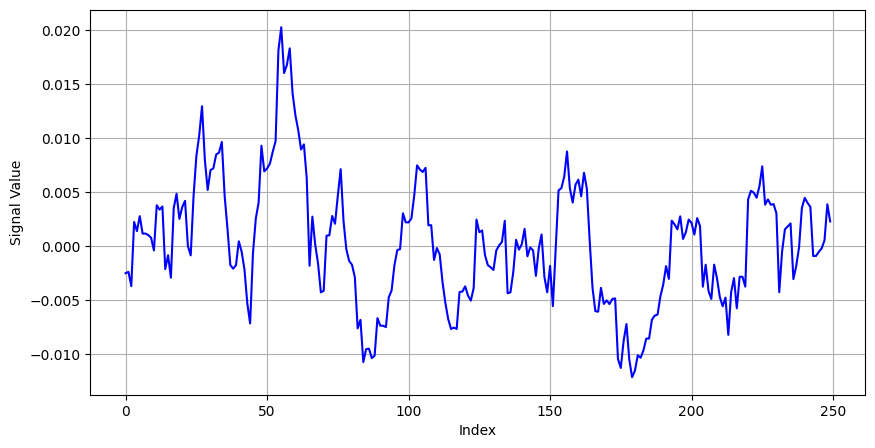

AI text signal


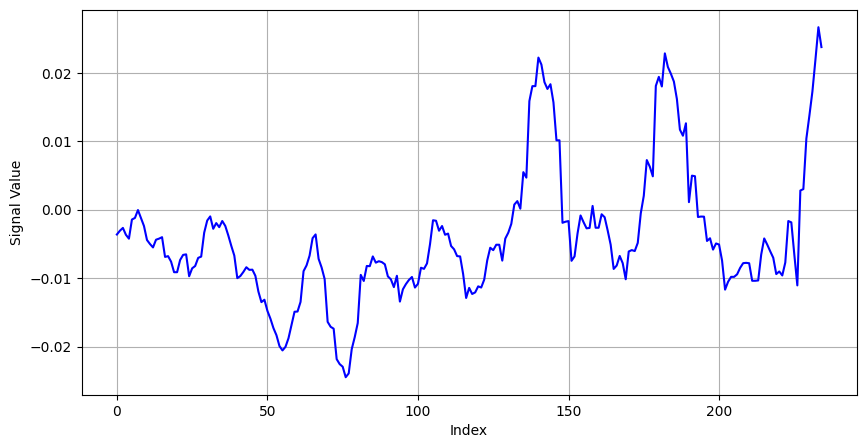

In [36]:
print("Human text signal")
human_text = train_df[train_df["target"] == 0]["text"].to_list()[0]
human_signal = get_signal(human_text)
plot_signal(human_signal, smoothing_factor=5)

print("AI text signal")
ai_text = train_df[train_df["target"] == 1]["text"].to_list()[0]
ai_signal = get_signal(ai_text)
plot_signal(ai_signal, smoothing_factor=5)

Human text signal: 513


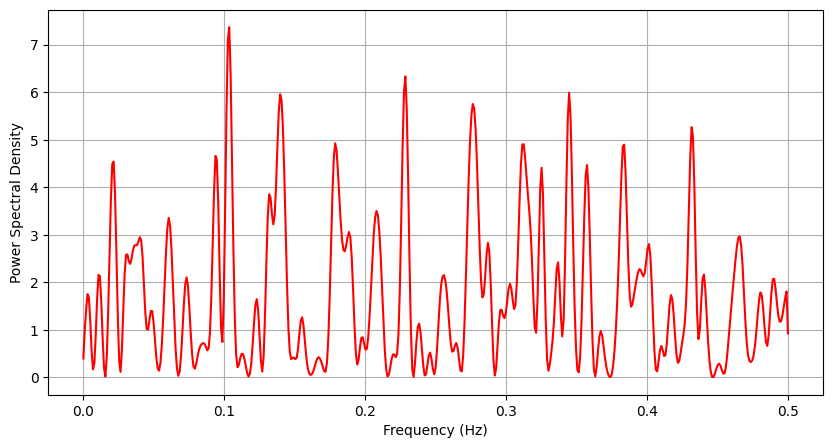

AI text signal: 513


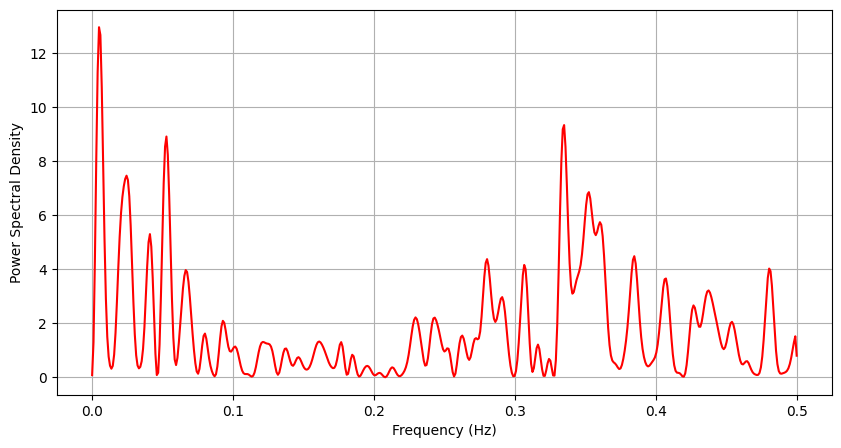

In [37]:
f, Pxx = compute_periodogram(human_signal)
print(f"Human text signal: {len(Pxx)}")
plot_periodogram(f, Pxx)

f, Pxx = compute_periodogram(ai_signal)
print(f"AI text signal: {len(Pxx)}")
plot_periodogram(f, Pxx)

In [39]:
periodograms = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    text = row["text"]
    label = row["target"]
    signal = get_signal(text)
    nperseg = min(len(signal), 256)
    frequencies, power_density = compute_periodogram(signal, nperseg=nperseg)
    periodograms.append({"frequencies": frequencies.tolist(), "power_density": power_density.tolist(), "label": label})

len(periodograms)

100%|██████████| 7554/7554 [00:21<00:00, 350.67it/s]


7554

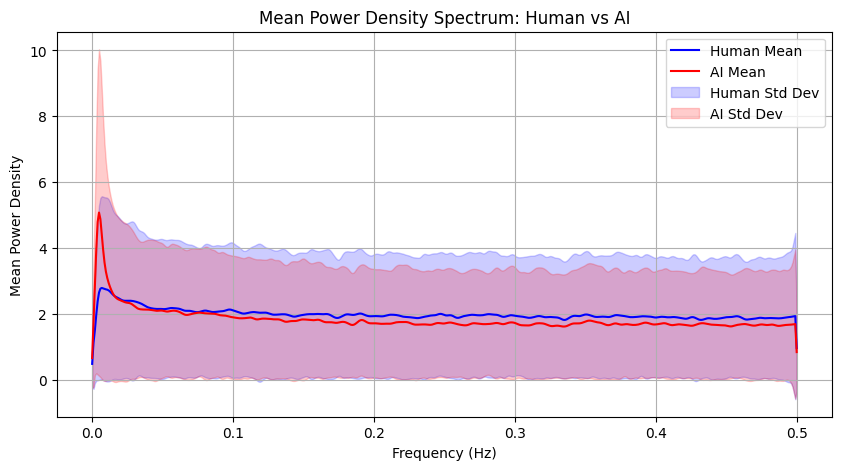

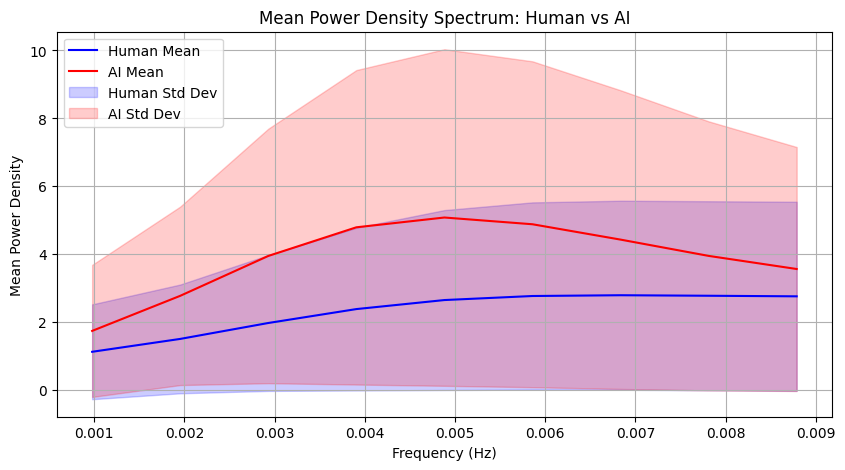

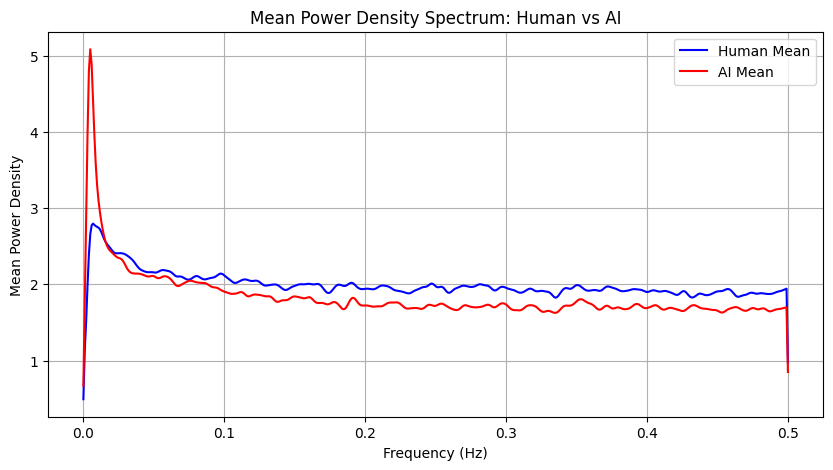

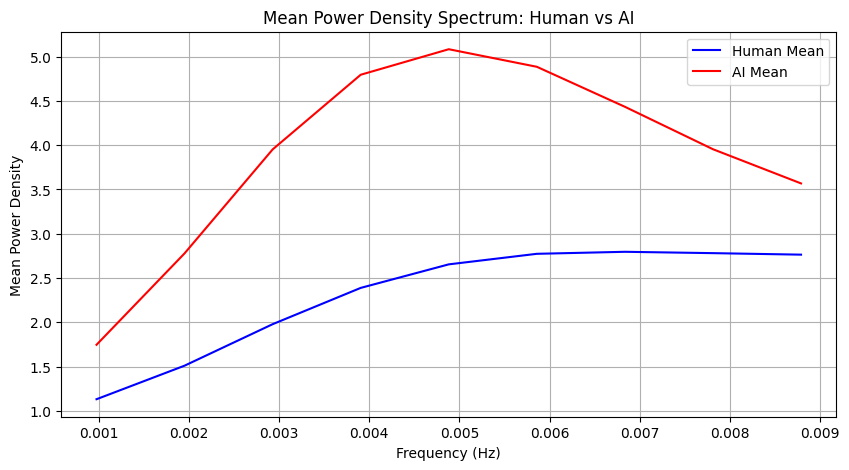

In [64]:
human_periodograms = [p["power_density"] for p in periodograms if p["label"] == 0]
mean_human_power_density = np.mean(human_periodograms, axis=0)
std_human_power_density = np.std(human_periodograms, axis=0)

ai_periodograms = [p["power_density"] for p in periodograms if p["label"] == 1]
mean_ai_power_density = np.mean(ai_periodograms, axis=0)
std_ai_power_density = np.std(ai_periodograms, axis=0)

begin, end = 1, 10

plot_ai_vs_human(mean_human_power_density, mean_ai_power_density, frequencies=f, std_ai=std_ai_power_density, std_human=std_human_power_density)
plot_ai_vs_human(mean_human_power_density, mean_ai_power_density, frequencies=f, begin=begin, end=end, std_ai=std_ai_power_density, std_human=std_human_power_density)
plot_ai_vs_human(mean_human_power_density, mean_ai_power_density, frequencies=f,)
plot_ai_vs_human(mean_human_power_density, mean_ai_power_density, frequencies=f, begin=begin, end=end)

In [65]:
from sklearn.model_selection import train_test_split

X = [p["power_density"][begin:end] for p in periodograms]
#X = [p["power_density"] for p in periodograms]
y = [p["label"] for p in periodograms]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6207809397749835
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.69      0.64       737
           1       0.65      0.55      0.60       774

    accuracy                           0.62      1511
   macro avg       0.62      0.62      0.62      1511
weighted avg       0.63      0.62      0.62      1511



In [67]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

y_pred_linear = linear_regressor.predict(X_test)

threshold = 0.5
y_pred_binary = [1 if pred >= threshold else 0 for pred in y_pred_linear]

accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

Accuracy: 0.6293845135671741
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.83      0.69       737
           1       0.73      0.44      0.55       774

    accuracy                           0.63      1511
   macro avg       0.66      0.63      0.62      1511
weighted avg       0.66      0.63      0.62      1511

